In [1]:
import sys
sys.path.append('/Users/laurenthericourt/projets/trading/trading')
import warnings
warnings.filterwarnings('ignore')
import random
from datetime import datetime, timedelta
from dateutil.rrule import rrule, WEEKLY, FR, SU

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from config.load import load_conf
from db.utils import get_uri_db
from utils.utils import get_candles
from indicator.trend import ExponentialMovingAverage
from notebooks.compute_indicators import moyenne_mobile_features
from utils.utils import compute_sign_changement
from notebooks.display_indicators import show_candle, add_indicator
from indicator.trend import BollingerBands, Slope
from indicator.oscillator import Atr, Obv
from indicator.trend import ExponentialMovingAverage, MovingAverage

# Get data

In [2]:
load_conf('../config/configuration.yaml')
dsn = get_uri_db()
schema = 'trading'

In [3]:
start_date = '2019-01-01'
end_date = '2021-01-01'

candles = get_candles(dsn, schema, start_date, end_date)

In [330]:
table = 'candle15m'
symbol = 'EUR/USD'

candles_to_show = candles[(candles['table'] == table) & (candles['symbol'] == symbol)].reset_index(drop=True)

# Find maxima

In [331]:
candles_to_show['atr'], _ = Atr(candles_to_show).compute(span=5, avg_type = 'ma')
candles_to_show.dropna(inplace=True)

In [332]:
from scipy.signal import argrelextrema

class Extrema(object):
    def __init__(self, candles, max_, atr_weight, atr_weight2, min_range, min_variance, ratio_pic_size):
        self.candles = candles.reset_index(drop=True)
        self.max = max_
        self.atr_weight = atr_weight
        self.atr_weight = atr_weight2
        self.min_range = min_range
        self.min_variance = min_variance
        self.ratio_pic_size = ratio_pic_size
    
    def _filter_by_atr(self, local_max_idx, local_max_values):
        local_max_idx_to_remove = list()
        for prev_idx, prev_val, idx, val in zip(local_max_idx[:-1], local_max_values[:-1], local_max_idx[1:], local_max_values[1:]):
            atr = self.candles.loc[idx, 'atr']
            #print(idx)
            if abs(val - prev_val) < self.atr_weight * atr and val > prev_val:
                #print(atr)
                local_max_idx_to_remove.append(prev_idx)
            elif abs(val - prev_val) < self.atr_weight * atr and val <= prev_val:
                #print(atr)
                local_max_idx_to_remove.append(idx)
        local_max_idx_filtered = [x for x in local_max_idx if x not in local_max_idx_to_remove]
        return local_max_idx_filtered
    
    def _filter_by_variance(self, local_max_idx, local_max_values):
        local_max_idx_to_remove = list()
        for prev_idx, prev_val, idx, val in zip(local_max_idx[:-1], local_max_values[:-1], local_max_idx[1:], local_max_values[1:]):
            candles_tmp = self.candles.loc[prev_idx : idx].copy()
            max_high = candles_tmp['high'].max()
            min_low = candles_tmp['low'].min()
            candles_tmp['range'] = candles_tmp['high'] - candles_tmp['low']
            max_range = max_high - min_low
            mean_range = candles_tmp['range'].mean()
            
            first_pic_range = candles_tmp.loc[prev_idx, 'range']
            last_pic_range = candles_tmp.loc[idx, 'range']
            if self.max and max_range < mean_range * self.min_variance and val > prev_val:
                local_max_idx_to_remove.append(prev_idx)
            elif self.max and max_range < mean_range * self.min_variance and val <= prev_val:
                local_max_idx_to_remove.append(idx)
            elif not self.max and max_range < mean_range * self.min_variance and val > prev_val:
                local_max_idx_to_remove.append(idx)
            elif not self.max and max_range < mean_range * self.min_variance and val <= prev_val:
                local_max_idx_to_remove.append(prev_idx)
            #elif (first_pic_range > max_range * self.ratio_pic_size or last_pic_range > max_range * self.ratio_pic_size) and val > prev_val:
            #    local_max_idx_to_remove.append(prev_idx)
            #elif (first_pic_range > max_range * self.ratio_pic_size or last_pic_range > max_range * self.ratio_pic_size) and val <= prev_val:
            #    local_max_idx_to_remove.append(idx)            
        local_max_idx_filtered = [x for x in local_max_idx if x not in local_max_idx_to_remove]
        return local_max_idx_filtered


    def _filter_close_values(self, local_max_idx, local_max_values):
        local_max_idx_to_remove = list()
        for prev_idx, prev_val, idx, val in zip(local_max_idx[:-1], local_max_values[:-1], local_max_idx[1:], local_max_values[1:]):
            if self.max and idx - prev_idx <= self.min_range and val > prev_val:
                local_max_idx_to_remove.append(prev_idx)
            elif self.max and idx - prev_idx <= self.min_range and val <= prev_val:
                local_max_idx_to_remove.append(idx)
            elif not self.max and idx - prev_idx <= self.min_range and val > prev_val:
                local_max_idx_to_remove.append(idx)
            elif not self.max and idx - prev_idx <= self.min_range and val <= prev_val:
                local_max_idx_to_remove.append(prev_idx)

        local_max_idx_filtered = [x for x in local_max_idx if x not in local_max_idx_to_remove]
        return local_max_idx_filtered


    def _filter_by_pattern(self, local_max_idx, local_max_values):
        local_max_idx_to_remove = list()
        for prev_idx, prev_val, idx, val, next_idx, next_val in zip(local_max_idx[:-2], local_max_values[:-2], local_max_idx[1:-1], local_max_values[1:-1], local_max_idx[2:], local_max_values[2:]):
            atr = self.candles.loc[idx, 'atr']
            if self.max and val < prev_val and val < next_val and prev_val - val > self.atr_weight * atr and next_val - val > self.atr_weight * atr:
                local_max_idx_to_remove.append(idx)
            elif not self.max and val > prev_val and val > next_val and val - prev_val > self.atr_weight * atr and val - prev_val > self.atr_weight * atr:
                local_max_idx_to_remove.append(idx)

        local_max_idx_filtered = [x for x in local_max_idx if x not in local_max_idx_to_remove]
        return local_max_idx_filtered
    
    
    def _get_all_extrema(self):
        idx_maxima = list()
        prev_rows = list()
        historic_len = 2
        for row in self.candles.itertuples():
            if int(row.Index) < historic_len:
                prev_rows.append(row)
                continue
            if self.max and prev_rows[-1].high >= row.high and prev_rows[-1].high >= prev_rows[-2].high:
                idx_maxima.append(int(prev_rows[-1].Index))
            elif not self.max and prev_rows[-1].low <= row.low and prev_rows[-1].low <= prev_rows[-2].low:
                idx_maxima.append(int(prev_rows[-1].Index))

            del prev_rows[0]
            prev_rows.append(row)
        
        return idx_maxima
                
            
            
    def get_max_extrema(self):

        #local_max_idx = argrelextrema(self.candles['high'].values, np.greater)[0]
        local_max_idx = self._get_all_extrema()
        local_max_values = self.candles.loc[local_max_idx, 'high'].values if self.max else self.candles.loc[local_max_idx, 'low'].values

        local_max_idx_filtered = self._filter_by_variance(local_max_idx, local_max_values)
        local_max_values_filtered = self.candles.loc[local_max_idx_filtered, 'high'].values

        local_max_idx_filtered = self._filter_close_values(local_max_idx_filtered, local_max_values_filtered)
        local_max_values_filtered = self.candles.loc[local_max_idx_filtered, 'high'].values
        
        local_max_idx_filtered = self._filter_by_variance(local_max_idx_filtered, local_max_values_filtered)
        local_max_values_filtered = self.candles.loc[local_max_idx_filtered, 'high'].values

        local_max_idx_filtered = self._filter_by_pattern(local_max_idx_filtered, local_max_values_filtered)
        local_max_values_filtered = self.candles.loc[local_max_idx_filtered, 'high'].values

        res = local_max_idx_filtered

        return res

In [333]:
def alternate_max_and_min(candles, idx_maxs, idx_mins):
    
    def _choose_between_two_indexes(candles, idx1, idx2, col):
        idx_to_remove = None
        if candles.loc[idx1, col] > candles.loc[idx2, col] and col == 'high':
            idx_to_remove = idx2
        elif candles.loc[idx1, col] < candles.loc[idx2, col] and col == 'low':
            idx_to_remove = idx2
        else:
            idx_to_remove = idx1
        return idx_to_remove
    
    def _detect_indexes_to_remove_one_way(candles, idxs1, idxs2, begin):
        col = 'high' if begin == 'max' else 'low'
        idxs1_to_remove = list()
        idxs2_for_loop = idxs2.copy()
        for prev_idx, idx in zip(idxs1[:-1], idxs1[1:]):
            if idxs2_for_loop and idx < idxs2_for_loop[0]:
                idxs1_to_remove.append(_choose_between_two_indexes(candles, prev_idx, idx, col))
            elif idxs2_for_loop:
                idxs2_for_loop = [x for x in idxs2_for_loop if x > idx]
            else:
                idxs1_to_remove.append(_choose_between_two_indexes(candles, prev_idx, idx, col))
        return idxs1_to_remove
    
    def _detect_indexes_to_remove_two_ways(candles, idxs1, idxs2, begin):
        idxs1_to_remove = _detect_indexes_to_remove_one_way(candles, idxs1, idxs2, begin)
        new_idxs1 = [x for x in idxs1 if x not in idxs1_to_remove]
        
        begin = 'max' if begin == 'min' else 'min'
        idxs2_to_remove = _detect_indexes_to_remove_one_way(candles, idxs2, new_idxs1[1:], begin)
        new_idxs2 = [x for x in idxs2 if x not in idxs2_to_remove]
                                       
        return new_idxs1, new_idxs2
    
    def _clean_commun_min_and_max_idxs(idxs_max, idxs_min):
        commun_idxs = set(idxs_max).intersection(set(idxs_min))
        idx_mins_to_remove = list()
        idx_maxs_to_remove = list()
        for idx in commun_idxs:
            idx_max_commun = idxs_max.index(idx)
            idx_min_commun = idxs_min.index(idx)
            if idx_max_commun > 0 and idx_min_commun > 0 and idxs_max[idx_max_commun - 1] > idxs_min[idx_min_commun - 1]:
                idx_maxs_to_remove.append(idx)
            elif idx_max_commun > 0 and idx_min_commun > 0 and idxs_max[idx_max_commun - 1] < idxs_min[idx_min_commun - 1]:
                idx_mins_to_remove.append(idx)
        new_idxs_max = [x for x in idxs_max if x not in idx_maxs_to_remove]
        new_idxs_min = [x for x in idxs_min if x not in idx_mins_to_remove]
        return new_idxs_max, new_idxs_min
    
    if idx_maxs[0] < idx_mins[0]:
        idx_maxs_new, idx_mins_new = _detect_indexes_to_remove_two_ways(candles, idx_maxs, idx_mins, begin='max')
    else:
        idx_mins_new, idx_maxs_new = _detect_indexes_to_remove_two_ways(candles, idx_mins, idx_maxs, begin='min')
    
    idx_maxs_new, idx_mins_new = _clean_commun_min_and_max_idxs(idx_maxs_new, idx_mins_new)
    
    return idx_maxs_new, idx_mins_new

# Show result

In [334]:
def show_random_cases(candles, nb_examples_to_show=30, nb_candles_to_show=50):
    cd = candles.copy().reset_index(drop=True)
    idx = cd.index.tolist()
    #random.seed(21)
    random.shuffle(idx)

    idx_to_show = idx[:nb_examples_to_show]
    
    for i, idx_candle in enumerate(idx_to_show):
        candles_to_show = cd.loc[idx_candle - nb_candles_to_show // 2 : idx_candle + nb_candles_to_show // 2].reset_index(drop=True)
        #idx_maxs = get_max_extrema(candles_to_show, atr_weight=0.2, atr_weight2=1, min_range=10)
        max_extrema = Extrema(candles_to_show, max_=True, atr_weight=0.2, atr_weight2=0.5, min_range=6, min_variance=2, ratio_pic_size=0.6)
        idx_maxs = max_extrema.get_max_extrema()
        min_extrema = Extrema(candles_to_show, max_=False, atr_weight=0.2, atr_weight2=0.5, min_range=6, min_variance=2, ratio_pic_size=0.6)
        idx_mins = min_extrema.get_max_extrema()
        idx_maxs, idx_mins = alternate_max_and_min(candles_to_show, idx_maxs, idx_mins)

        if i % 2 == 0:
            fig = make_subplots(rows=1, cols=2)
        
        fig.update_layout(xaxis1_rangeslider_visible=False, xaxis2_rangeslider_visible=False)

        width = 2
        color = 'rgba(46, 134, 193, 0.5)'
        fig.add_trace(go.Candlestick(x=candles_to_show['date'],
                                     open=candles_to_show['open'],
                                     high=candles_to_show['high'],
                                     low=candles_to_show['low'],
                                     close=candles_to_show['close'],
                                     showlegend=False),
                      row=1, col= i % 2 + 1)
        
        fig.add_trace(
            go.Scatter(
                mode='markers',
                x=candles_to_show.loc[idx_maxs, 'date'],
                y=candles_to_show.loc[idx_maxs, 'high'],
                marker=dict(
                    color='MediumPurple',
                    size=8,
                ),
                showlegend=False,
            ),
            row=1, col= i % 2 + 1
        )
        
        fig.add_trace(
            go.Scatter(
                mode='markers',
                x=candles_to_show.loc[idx_mins, 'date'],
                y=candles_to_show.loc[idx_mins, 'low'],
                marker=dict(
                    color='mediumblue',
                    size=8,
                ),
                showlegend=False,
            ),
            row=1, col= i % 2 + 1
        )

        if i % 2 == 1:
            fig.show()

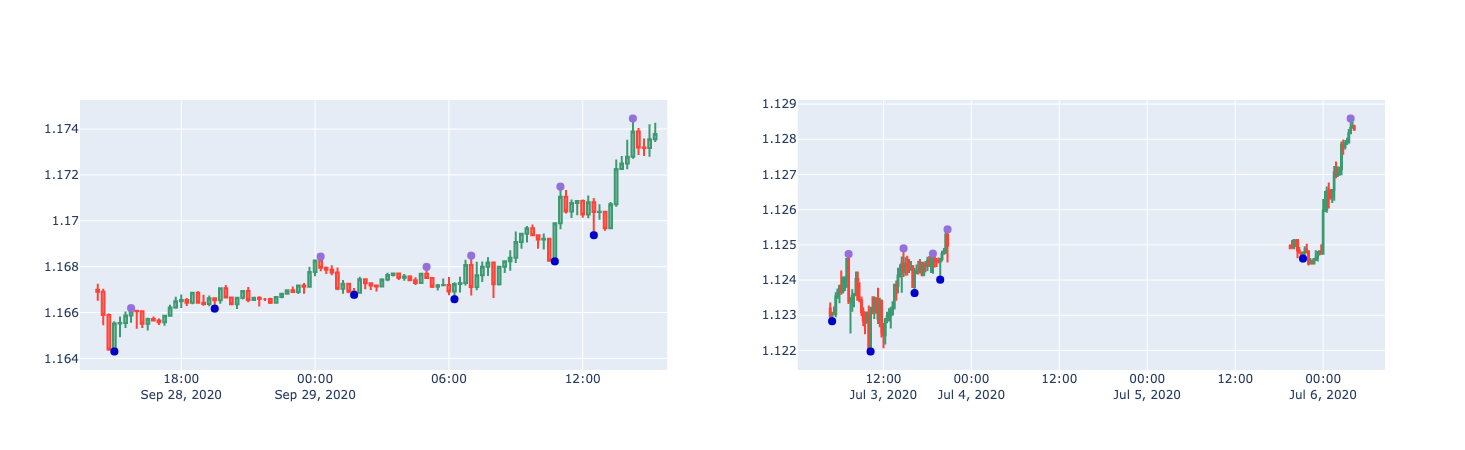

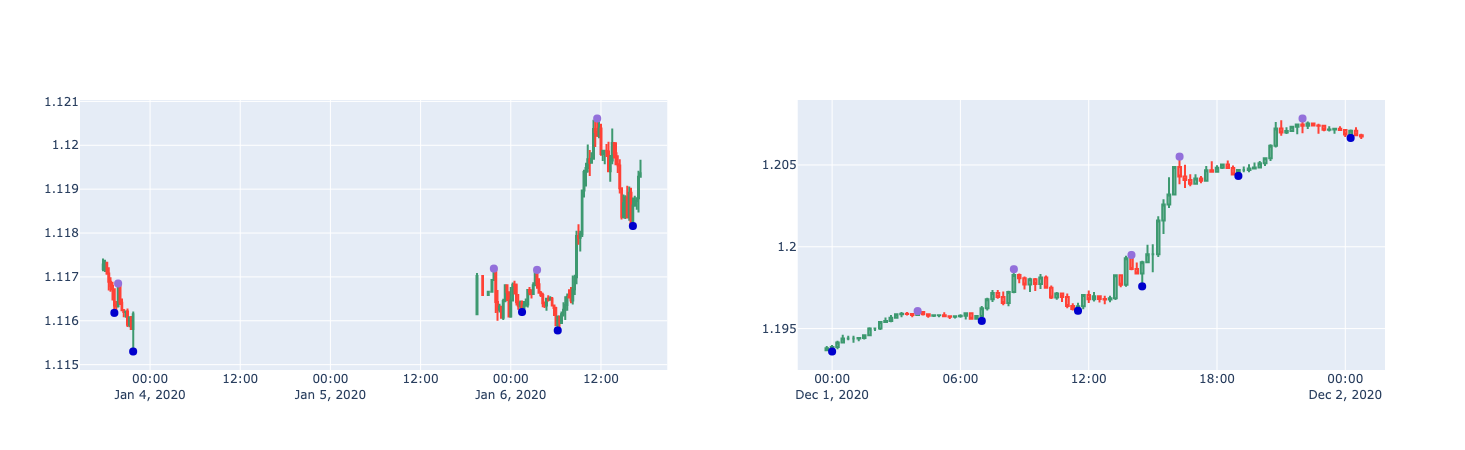

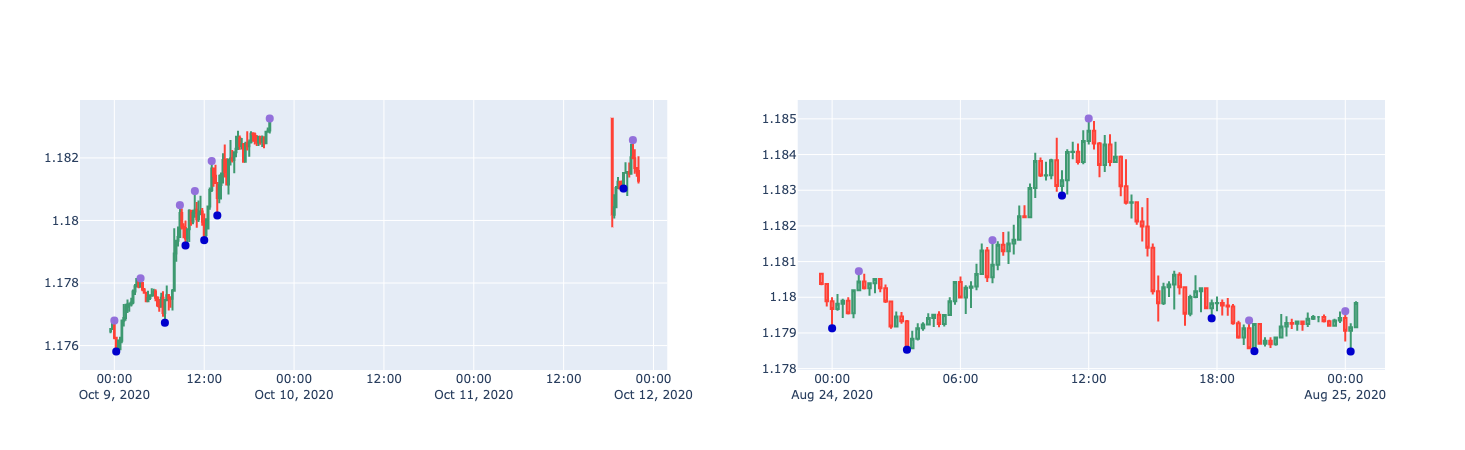

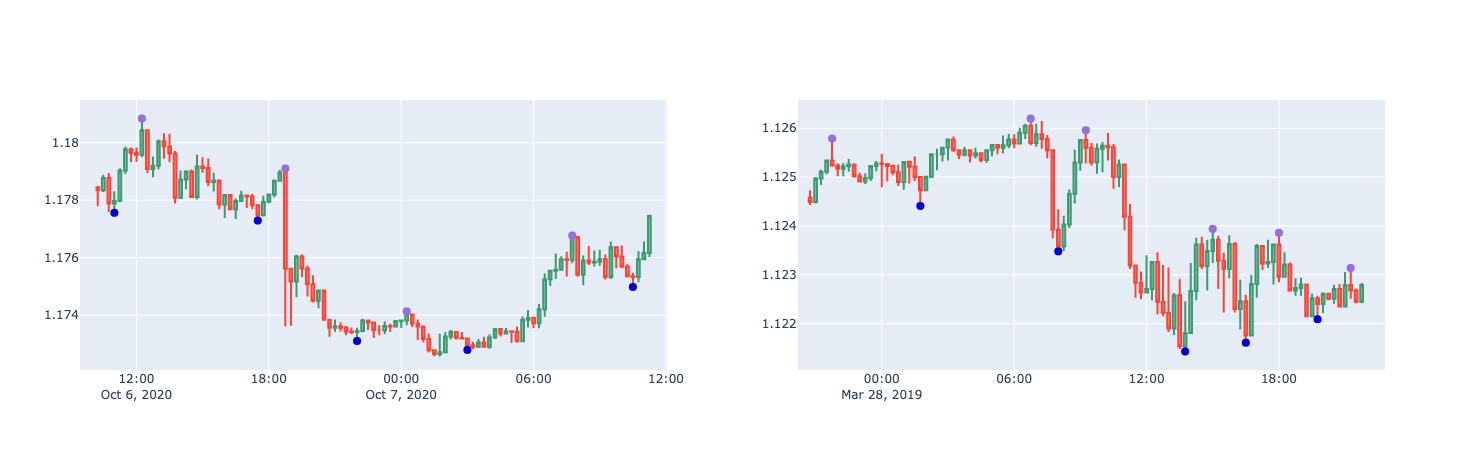

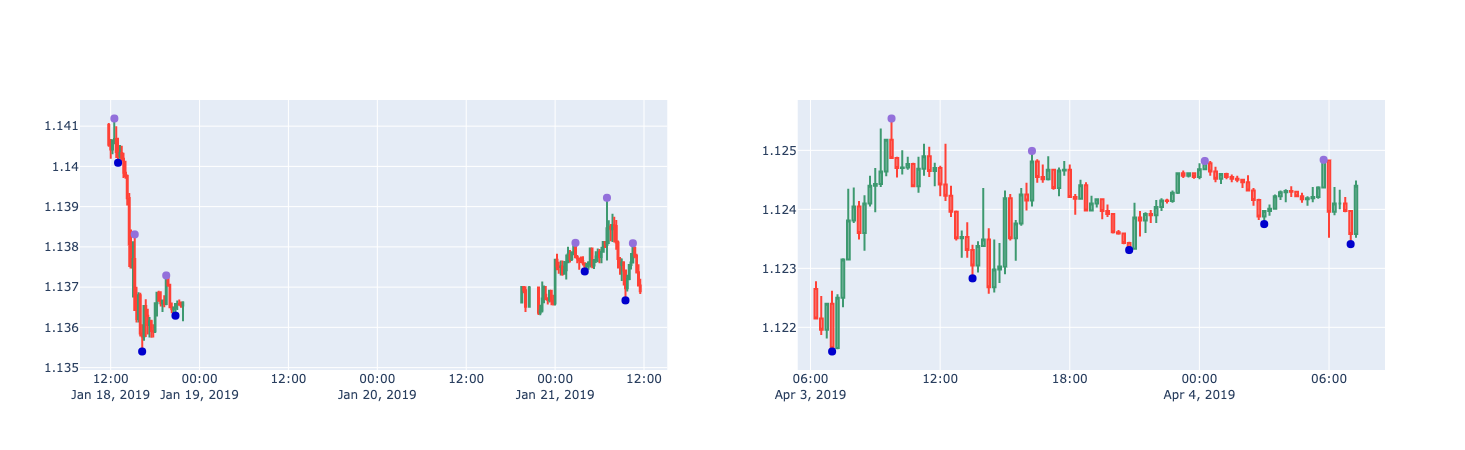

In [336]:
show_random_cases(candles_to_show, nb_examples_to_show=10, nb_candles_to_show=100)